In [30]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from numpy.linalg import norm

In [2]:
import sys
sys.path.append("./Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

https://pubs.acs.org/doi/abs/10.1021/ed078p391

In [3]:
print(bse.get_basis("pcX-1",fmt="nwchem",elements=["C",7,8,9]))

#----------------------------------------------------------------------
# Basis Set Exchange
# Version v0.8.13
# https://www.basissetexchange.org
#----------------------------------------------------------------------
#   Basis set: pcX-1
# Description: Jensen pcX basis set optimized for core-spectroscopy
#        Role: orbital
#     Version: 1  (Data from Frank Jensen)
#----------------------------------------------------------------------


BASIS "ao basis" PRINT
#BASIS SET: (7s,4p,1d) -> [7s,4p,1d]
C    S
      0.147726E+04           1.0000000
C    S
      0.222361E+03           1.0000000
C    S
      0.505229E+02           1.0000000
C    S
      0.139594E+02           1.0000000
C    S
      0.421475E+01           1.0000000
C    S
      0.653345E+00           1.0000000
C    S
      0.191501E+00           1.0000000
C    P
      0.109571E+02           1.0000000
C    P
      0.232904E+01           1.0000000
C    P
      0.633257E+00           1.0000000
C    P
      0.163150E+00        

In [4]:
n_pcx1=gto.basis.load(bse.get_basis("pcX-1",fmt="nwchem",elements=["N"]),"N")
n_pcx1

[[0, [2004.67, 1.0]],
 [0, [301.707, 1.0]],
 [0, [68.5611, 1.0]],
 [0, [18.9925, 1.0]],
 [0, [5.76941, 1.0]],
 [0, [0.916175, 1.0]],
 [0, [0.264783, 1.0]],
 [1, [14.9507, 1.0]],
 [1, [3.21784, 1.0]],
 [1, [0.87044, 1.0]],
 [1, [0.218852, 1.0]],
 [2, [0.948683, 1.0]]]

In [5]:
c_pcx1=gto.basis.load(bse.get_basis("pcX-1",fmt="nwchem",elements=["C"]),"C")
o_pcx1=gto.basis.load(bse.get_basis("pcX-1",fmt="nwchem",elements=["O"]),"O")
f_pcx1=gto.basis.load(bse.get_basis("pcX-1",fmt="nwchem",elements=["F"]),"F")

In [6]:
#n_pcx1,m_pcx1,c_pcx1

In [7]:
m1=gto.M(atom="N 0 0 0; N 0 0 2.01",unit="Bohrs",basis={"N":n_pcx1})
m2=gto.M(atom="N1 0 0 0; N2 0 0 2.01",unit="Bohrs",basis={"N1":c_pcx1,"N2":o_pcx1})

In [8]:
mf1=scf.RHF(m1)
mf1.scf()
mf2=scf.RHF(m2)
mf2.scf()

converged SCF energy = -108.917141764211
converged SCF energy = -108.891229528654


-108.89122952865374

In [133]:
def sto(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("sto-3G",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=sto(ref)
        rbm=sto(ref-1)
        rbp=sto(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):
            for j in range(1,len(fb[i])):  # ref+a(z-zr) +b(z-zr)^2
                a=(rbp[i][j][0]-rbm[i][j][0])/2
                b=(rbp[i][j][0]+rbm[i][j][0]-2*rb[i][j][0])
                fb[i][j][0]+=a*(z-ref)+b*(z-ref)**2/2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [186]:
def pcX(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("pcX-1",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=pcX(ref)
        rbm=pcX(ref-1)
        rbp=pcX(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  # ref+a(z-zr) +b(z-zr)^2
            a=(rbp[i][1][0]-rbm[i][1][0])/2
            b=(rbp[i][1][0]+rbm[i][1][0]-2*rb[i][1][0])
            #fb[i][1][0]+=a*np.sign(z-ref)*abs(z-ref)*3            
            fb[i][1][0]+=a*(z-ref)+b*(z-ref)**2/2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [179]:
dl=.1
zt=1
Ps=np.asarray([P(-2*dl),P(-dl),p_nn,P(dl),P(2*dl)])
apdft=[p_nn]
inc=[]
for i in range(4):
    inc.append(np.einsum('i,ijk->jk',fds5[i+1],Ps)/dl**(i+1)/np.math.factorial(i+1)*zt**(i+1))
    apdft.append(apdft[i]+inc[-1] )
pT=P(zt)
for i in range(len(apdft)):
    print (norm(apdft[i]-pT),norm(inc[i-1]))

0.9650411894373281 122.81720916209498
4.574926965259624 5.168827460351586
10.399776215235999 9.588200728792538
40.84188093932736 43.57382089120653
120.96252464495062 122.81720916209498


In [156]:
pcX(6.99,ref=6),pcX(7,ref=6)

([[0, [1999.0080675, 1.0]],
  [0, [300.85521415, 1.0]],
  [0, [68.367460415, 1.0]],
  [0, [18.938435116, 1.0]],
  [0, [5.7526783205, 1.0]],
  [0, [0.9133328402, 1.0]],
  [0, [0.26398968605, 1.0]],
  [1, [14.909147825000002, 1.0]],
  [1, [3.2085476345000004, 1.0]],
  [1, [0.8679777731, 1.0]],
  [1, [0.21829052995, 1.0]],
  [2, [0.9476816579, 1.0]]],
 [[0, [2004.67, 1.0]],
  [0, [301.707, 1.0]],
  [0, [68.5611, 1.0]],
  [0, [18.9925, 1.0]],
  [0, [5.76941, 1.0]],
  [0, [0.916175, 1.0]],
  [0, [0.264783, 1.0]],
  [1, [14.9507, 1.0]],
  [1, [3.21784, 1.0]],
  [1, [0.87044, 1.0]],
  [1, [0.218852, 1.0]],
  [2, [0.948683, 1.0]]])

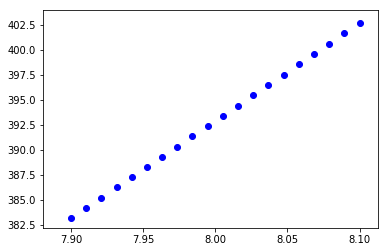

In [84]:
x=np.linspace(7.9,8.1,20)
for i in x:
    plt.scatter(i,pcX(i,ref=8)[1][1][0],color="blue")

In [88]:
mf_co=scf.RHF(gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohrs",basis=bse.get_basis("pcX-1"\
                                                       ,fmt="nwchem",elements=["C","N","O"])))
mf_co.scf()
p_co=mf_co.make_rdm1()
mf_nn=scf.RHF(gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("pcX-1"\
                                                       ,fmt="nwchem",elements=["C","N","O"])))
mf_nn.scf()
p_nn=mf_nn.make_rdm1()

converged SCF energy = -112.716141826715
converged SCF energy = -108.916591616523


In [85]:
def E(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7-l,ref=7),"N2":pcX(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7,ref=7),"N2":pcX(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=p_nn)
    return e

In [184]:
def E_nc(l,zbs=True):
    mol_l=gto.M(atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7-l,ref=7),"N2":pcX(7+l,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=p_nn)
    return e

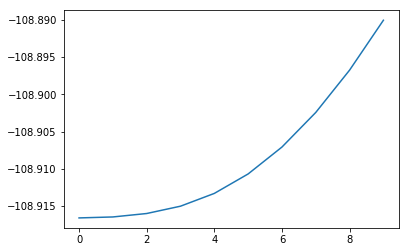

In [192]:
print(scipy.polyfit(np.linspace(0,1,10),a,8))
print(scipy.polyfit(np.linspace(0,1,10),b,8))

[-7.50338295e-04 -1.28786063e-02  6.70613110e-02 -1.22800987e-01
  9.58058691e-02 -1.09588949e-02  1.11100386e-02 -5.28704132e-05
 -1.08916592e+02]
[-9.25823591e-04 -9.28322473e-03  5.29369618e-02 -9.98958116e-02
  8.46626485e-02 -8.96749479e-03 -3.81803408e+00 -4.33875566e-05
 -1.08916592e+02]


In [142]:
def P(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7-l,ref=7),"N2":pcX(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7,ref=7),"N2":pcX(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    mf_l.conv_tol=1e-12
    mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return mf_l.make_rdm1()
P(0.5).shape

(48, 48)

In [119]:
eT_R=E(-1,zbs=False)
p_co_nn=P(1,zbs=False)

In [120]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [143]:
dl=.3
Ps=np.asarray([P(-3*dl),P(-2*dl),P(-dl),p_nn,P(dl),P(2*dl),P(3*dl)])
apdft=[p_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,ijk->jk',fds7[i+1],Ps)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
for i in range(len(apdft)):
    print (norm(apdft[i]-P(1)))

0.9650411894370384
1.0362398716483971
1.3275182527882015
1.369120117676861
1.6444489592192824
1.2791717458291731
0.13963271481357975


In [154]:
dl=.1
zt=.4
Ps=np.asarray([P(-2*dl),P(-dl),p_nn,P(dl),P(2*dl)])
apdft=[p_nn]
inc=[]
for i in range(4):
    inc.append(np.einsum('i,ijk->jk',fds5[i+1],Ps)/dl**(i+1)/np.math.factorial(i+1)*zt**(i+1))
    apdft.append(apdft[i]+inc[-1] )
for i in range(len(apdft)):
    print (norm(apdft[i]-P(zt)),norm(inc[i-1]))

0.6118138270624611 0.08532562319735701
0.19766558694046893 0.7296785901819043
0.15864057827796216 0.201172431006975
0.07277136847471434 0.17029847817731433
0.0321780945813325 0.08532562319735701


In [155]:
dl=.1
zt=.4
Ps=np.asarray([P(-2*dl),P(-dl),p_nn,P(dl),P(2*dl)])
apdft=[p_nn]
inc=[]
for i in range(4):
    inc.append(np.einsum('i,ijk->jk',fds5[i+1],Ps)/dl**(i+1)/np.math.factorial(i+1)*zt**(i+1))
    apdft.append(apdft[i]+inc[-1] )
pT=P(zt)
for i in range(len(apdft)):
    print (norm(apdft[i]-pT),norm(inc[i-1]))

0.6118138270624792 0.0853256231969168
0.19766558694024813 0.7296785901819134
0.15864057827742423 0.20117243100709462
0.07277136847414147 0.17029847817657845
0.03217809458007389 0.0853256231969168


In [125]:
dl=.3
Ps=np.asarray([P(-3*dl,zbs=False),P(-2*dl,zbs=False),P(-dl,zbs=False),p_nn,P(dl,zbs=False),P(2*dl,zbs=False),P(3*dl,zbs=False)])
apdft=[p_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,ijk->jk',fds7[i+1],Ps)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
for i in range(len(apdft)):
    print (norm(apdft[i]),norm(apdft[i]-p_co_nn))

2.921781555698277 1.4072832721876174
3.2383524682303553 0.493792853822984
3.122894466872578 0.12076365468397218
3.0916927283164006 0.03144584683536064
3.0893377372349087 0.00872844830116007
3.088367144499512 0.0027459879653724314
3.0888398989796846 8.840767518070873e-05


In [94]:
norm(P(.9999)-p_co)

6.574730312539663e-05

In [ ]:
dl=.1
zt=.4
Es=np.asarray([P(-2*dl),P(-dl),p_nn,P(dl),P(2*dl)])
apdft=[p_nn]
inc=[]
for i in range(4):
    inc.append(np.einsum('i,ijk->jk',fds5[i+1],Ps)/dl**(i+1)/np.math.factorial(i+1)*zt**(i+1))
    apdft.append(apdft[i]+inc[-1] )
pT=P(zt)
for i in range(len(apdft)):
    print (norm(apdft[i]-pT),norm(inc[i-1]))

Conclusions: the series is even harder to converge for density matrices, the radius of convergence is around .5 whereas to get the  <br>
the issue is contained in the derivatives with respect to the orbital coefficients. <br>
Better not to include this in a future article
